In [1]:
suppressMessages(library(rwwa))

rnm <- "kr"
nsamp <- 1000

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# specify arguments for all models
hdwi_args <- list(dist = "gev", type = "shift", varnm = "x", covnm = c("gmst"), lower = F)
pr_args <- list(dist = "norm", type = "shift", varnm = "x", covnm = c("gmst"), lower = T)
tx_args <- list(dist = "gev", type = "shift", varnm = "x", covnm = c("gmst"), lower = F)
wind_args <- list(dist = "gev", type = "shift", varnm = "x", covnm = c("gmst"), lower = F)
vpd_args <- list(dist = "gev", type = "shift", varnm = "x", covnm = c("gmst"), lower = F)
hursmin_args <- list(dist = "gev", type = "shift", varnm = "x", covnm = c("gmst"), lower = T)

rp_list <- list("hdwi" = 100, "tx5x" = 100, "pr-fm" = 5, "sfcWindmax5x" = 5)

# 2.1 - trends in HDWI

In [6]:
varnm <- "hdwi"

gmst <- read.table("ts-kr/gmst.txt", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2025]

cov_2025 <- gmst[gmst$year == 2025,"gmst",drop = F]
cov_pi <- cov_2025 - 1.3

ts <- load_ts("ts-kr/korea-fires_hdwi5x_ERA5land_kr.dat", col.names = c("year", "x"))
df <- merge(gmst, ts)

mdl_args <- switch(varnm, "hdwi" = hdwi_args, "pr-fm" = pr_args, "tx5x" = tx_args, "sfcWindmax5x" = wind_args)
mdl <- do.call(fit_ns, append(mdl_args, list("data" = df)))

# # not sure why confidence region for return level plot isn't working, will compute manually
x_ci <- c(5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000)
# cov_f <- cov_2025; cov_cf <- cov_pi
# nsamp <- 1000
# set.seed(42)
# mdl_df <- mdl$data
# boot_res <- sapply(1:nsamp, function(i) {
#     boot_df <- mdl_df[sample(1:nrow(mdl_df), nrow(mdl_df), replace = T), ]
#     z <- tryCatch({
#         boot_mdl <- refit(mdl, boot_df)
#         c(map_from_u(boot_mdl, 1/x_ci, fixed_cov = cov_f), 
#           map_from_u(boot_mdl, 1/x_ci, fixed_cov = cov_cf))
#     }, error = function(cond) {
#         return(rep(NA, length(x_ci) * 2))
#     })
# })
# write.csv(boot_res, "boostrap-for-rlplot-ci_hdwi5x.csv", row.names = F)

boot_res <- read.csv("boostrap-for-rlplot-ci_hdwi5x.csv")
est_ci <- apply(boot_res, 1, quantile, c(0.025, 0.975), na.rm = T)

In [7]:
png("fig/fig2-1_trend-in-hdwi.png", height = 360, width = 360 * 7/5*2); {
    prep_window(c(1,2), mar = c(3,4,3,1), lwd = 2)

    plot_trend(mdl, add_loess = T, xlab = "", ylab = "HDWI5x", main = "(a) Trend in March HDWI5x as a function of time")
    plot_covtrend(mdl, "gmst", add_loess = T, xlab = "", ylab = "HDWI5x", main = "(a) Trend in March HDWI5x as a function of GMST")
}; dev.off()

png 
  2

In [15]:
png("fig/fig2-1_trend-in-hdwi_with-RLplot.png", height = 240, width = 240 * 7/5*3); {
    prep_window(c(1,3), mar = c(4,4,3,1), lwd = 2)

    plot_trend(mdl, add_loess = T, xlab = "", ylab = "", main = "(a) Trend in March HDWI5x as a function of time")
    mtext("Year", line = 2.5, side = 1)
    mtext("HDWI5x", line = 2.5, side = 2)
    plot_covtrend(mdl, "gmst", add_loess = T, xlab = "GMST anomaly (degC)", ylab = "HDWI5x", main = "(a) Trend in March HDWI5x as a function of GMST")
    plot_returnlevels(mdl, cov_f = cov_2025, cov_cf = cov_pi, nsamp = NA, ylab = "HDWI5x", main = "(c) Return level curves for fitted model")
    polygon(x = c(x_ci, rev(x_ci)), y = c(est_ci[1, 1:length(x_ci)], 
        rev(est_ci[2, 1:length(x_ci)])), density = NULL, 
        border = NA, col = adjustcolor("firebrick", 0.1))
    polygon(x = c(x_ci, rev(x_ci)), y = c(est_ci[1, -(1:length(x_ci))], 
        rev(est_ci[2, -(1:length(x_ci))])), density = NULL, 
        border = NA, col = adjustcolor("blue", 0.1))
}; dev.off()

png 
  2

# 2.2 - trends in HDWI components

In [58]:
gmst <- read.table("ts-kr/gmst.txt", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2025]

cov_2025 <- gmst[gmst$year == 2025,"gmst",drop = F]
cov_pi <- cov_2025 - 1.3

vpd <- load_ts("ts-kr/korea-fires_vpd5x_ERA5land_kr.dat", col.names = c("year", "x"))
tasmax <- load_ts("ts-kr/korea-fires_tx5x_ERA5land_kr.dat", col.names = c("year", "x"))
sfcWindmax1x <- load_ts("ts-kr/korea-fires_sfcWindmax1x_ERA5land_kr.dat", col.names = c("year", "x"))
sfcWindmax5x <- load_ts("ts-kr/korea-fires_sfcWindmax5x_ERA5land_kr.dat", col.names = c("year", "x"))
hursmin <- load_ts("ts-kr/korea-fires_hursmin5n_ERA5land_kr.dat", col.names = c("year", "x"))

In [47]:
# get actual values during HDWI spike
df <- read.csv("data/hdwi-vars_era5land_kr.csv")

In [48]:
event_values <- as.list(colMeans(df[(df$time >= "2025-03-22") & (df$time <= "2025-03-26") ,-1]))

In [72]:
ev1x <- df[df$time == "2025-03-25",]

In [59]:
mdl_vpd <- do.call(fit_ns, append(vpd_args, list("data" = merge(gmst, vpd), "ev" = event_values$vpdmax, "ev_year" = 2025)))
mdl_tasmax <- do.call(fit_ns, append(tx_args, list("data" = merge(gmst, tasmax), "ev" = event_values$tasmax, "ev_year" = 2025)))
mdl_wind <- do.call(fit_ns, append(wind_args, list("data" = merge(gmst, sfcWindmax1x))))
mdl_wind5x <- do.call(fit_ns, append(wind_args, list("data" = merge(gmst, sfcWindmax5x), "ev" = event_values$sfcWindmax, "ev_year" = 2025))
mdl_hursmin <- do.call(fit_ns, append(hursmin_args, list("data" = merge(gmst, hursmin), "ev" = event_values$hursmin, "ev_year" = 2025)))

In [78]:
res = 200
png("fig/fig2-2_trends-in-hdwi-components.png", height = res, width = res * 4); {
    
    prep_window(c(1,4), mar = c(3,4,3,1), lwd = 2)

    plot_trend(mdl_wind, main = "(a) sfcWindmax1x", ylim = c(4,11), ylab = "", ev = ev1x$sfcWindmax, ev_year = 2025, add_loess = T)
    mtext("Maximum daily windspeed (m/s)", line = 2.5, side = 2, cex = 0.8)
    plot_trend(mdl_vpd, main = "(b) vpd5x", ylim = c(0.5,3), ylab = "", ev = event_values$vpdmax, ev_year = 2025, add_loess = T)
    mtext("Vapour-pressure deficit (kPa)", line = 2.5, side = 2, cex = 0.8)
    plot_trend(mdl_tasmax, main = "(c) tx5x", ylim = c(8,22), ylab = "", ev = event_values$tasmax, ev_year = 2025, add_loess = T)
    mtext("Daily maximum temperatures (C)", line = 2.5, side = 2, cex = 0.8)
    plot_trend(mdl_hursmin, main = "(d) hursmin5n", ylim = c(20,50), ylab = "", ev = event_values$hursmin, ev_year = 2025, add_loess = T)
    mtext("Relative humidity (%)", line = 2.5, side = 2, cex = 0.8)
    
}; dev.off()

png 
  2

In [77]:
res = 200
png("fig/fig2-3_gmsttrends-in-hdwi-components.png", height = res, width = res * 4); {
    
    prep_window(c(1,4), mar = c(4,4,3,1), lwd = 2)

    plot_covtrend(mdl_wind, "gmst", main = "(a) sfcWindmax1x", ylim = c(4,11), ylab = "", ev = ev1x$sfcWindmax, ev_x = 0, add_loess = T, legend_pos = NA)
    mtext("Maximum daily windspeed (m/s)", line = 2.5, side = 2, cex = 0.8)
    plot_covtrend(mdl_vpd, "gmst", main = "(b) vpd5x", ylim = c(0.5,3), ylab = "", ev = event_values$vpdmax, ev_x = 0, add_loess = T, legend_pos = NA)
    mtext("Vapour-pressure deficit (kPa)", line = 2.5, side = 2, cex = 0.8)
    plot_covtrend(mdl_tasmax, "gmst", main = "(c) tx5x", ylim = c(8,22), ylab = "", ev = event_values$tasmax, ev_x = 0, add_loess = T, legend_pos = NA)
    mtext("Daily maximum temperatures (C)", line = 2.5, side = 2, cex = 0.8)
    plot_covtrend(mdl_hursmin, "gmst", main = "(d) hursmin5n", ylim = c(20,50), ylab = "", ev = event_values$hursmin, ev_x = 0, add_loess = T, legend_pos = NA)
    mtext("Relative humidity (%)", line = 2.5, side = 2, cex = 0.8)
    
}; dev.off()

In [89]:
cor(cbind("VPD" = vpd$x, "tmax" = tasmax$x, "hurs" = hursmin$x), method = "pearson")

,VPD,tmax,hurs
VPD,1.0000000,0.8683908,-0.3456035
tmax,0.8683908,1.0000000,-0.1569260
hurs,-0.3456035,-0.1569260,1.0000000


In [83]:
?cor

cor {stats},R Documentation
x,"a numeric vector, matrix or data frame."
y,"NULL (default) or a vector, matrix or data frame with compatible dimensions to x. The default is equivalent to y = x (but more efficient)."
na.rm,logical. Should missing values be removed?
use,"an optional character string giving a method for computing covariances in the presence of missing values. This must be (an abbreviation of) one of the strings ""everything"", ""all.obs"", ""complete.obs"", ""na.or.complete"", or ""pairwise.complete.obs""."
method,"a character string indicating which correlation coefficient (or covariance) is to be computed. One of ""pearson"" (default), ""kendall"", or ""spearman"": can be abbreviated."
V,"symmetric numeric matrix, usually positive definite such as a covariance matrix."


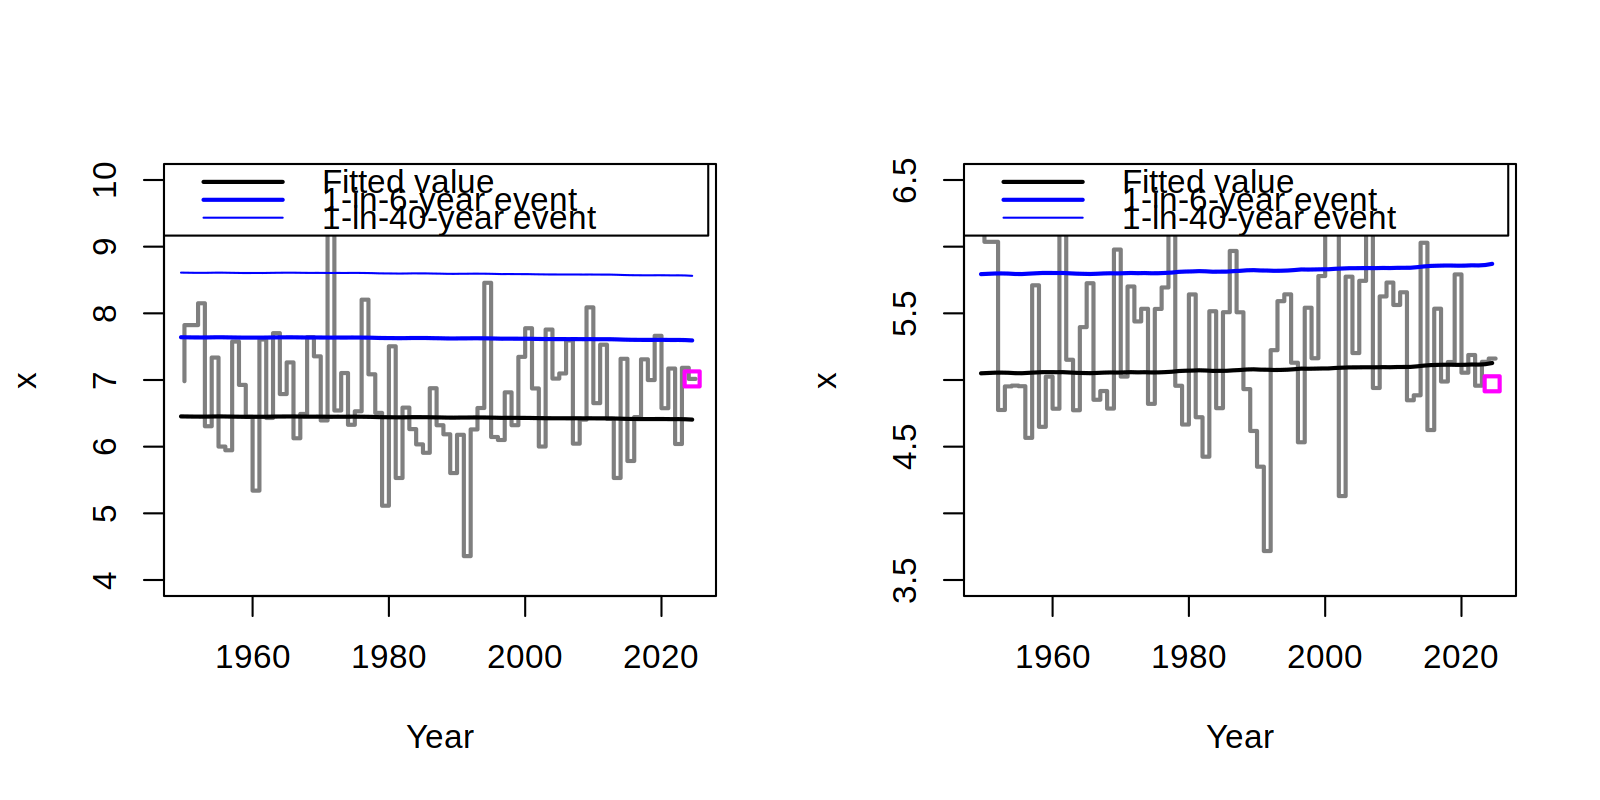

In [52]:
prep_window(c(1,2))

plot_trend(mdl_wind)
plot_trend(mdl_wind5x, ev = event_values$sfcWindmax, ev_year = 2025)